 # How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
!conda list | grep pandas_datareader

In [3]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces yfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

The `crypto.h5` store can be generated using the crypto notebooks in data folder.

We load crypto minute data which is upsampled (probably hourly).

Set data store location:

In [5]:
DATA_STORE = '../data/crypto.h5'

In [6]:
START = 2000
END = 2021

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['crypto/caggle/prices']).sort_index()
              # .loc[idx[START:END, :], ohlcv]
              #.rename(columns=lambda x: x.replace('adj_', ''))
              #.assign(volume=lambda x: x.volume.div(1000))
              #.swaplevel()
    cryptos = (store['coingecko/top100/market'])
    categories = store['coingecko/top100/cats']
prices.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 48918134 entries, (Timestamp('2013-04-01 00:07:00'), 'btc', 'usd') to (Timestamp('2021-05-18 07:04:00'), 'luna', 'usd')
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 2.3+ GB


In [8]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 48918134 entries, (Timestamp('2013-04-01 00:07:00'), 'btc', 'usd') to (Timestamp('2021-05-18 07:04:00'), 'luna', 'usd')
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 2.3+ GB


In [9]:
prices

open     high      low    close  \
date                symbol base                                       
2013-04-01 00:07:00 btc    usd    93.250   93.300   93.250   93.250   
2013-04-01 00:08:00 btc    usd   100.000  100.000  100.000  100.000   
2013-04-01 00:09:00 btc    usd    93.300   93.300   93.300   93.300   
2013-04-01 00:10:00 btc    usd    93.300   93.300   93.300   93.300   
2013-04-01 00:11:00 btc    usd    93.350   93.470   93.350   93.350   
...                                  ...      ...      ...      ...   
2021-05-18 07:01:00 luna   usd    15.376   15.406   15.376   15.376   
                    sol    usd    50.304   50.304   50.301   50.304   
2021-05-18 07:02:00 luna   usd    15.420   15.425   15.420   15.420   
2021-05-18 07:03:00 luna   usd    15.438   15.438   15.438   15.438   
2021-05-18 07:04:00 luna   usd    15.448   15.448   15.448   15.448   

                                      volume  
date                symbol base               
2013-04-01 00:07:00 btc    usd     93.300000  
2013-04-01 00:08:00 btc    usd     93.300000  
2013-04-01 00:09:00 btc    usd     33.676862  
2013-04-01 00:10:00 btc    usd      0.000000  
2013-04-01 00:11:00 btc    usd     20.000000  
...                                      ...  
2021-05-18 07:01:00 luna   usd    579.298200  
                    sol    usd     36.807817  
2021-05-18 07:02:00 luna   usd   1198.383100  
2021-05-18 07:03:00 luna   usd     17.528177  
2021-05-18 07:04:00 luna   usd     34.593475  

[48918134 rows x 5 columns]

In [10]:
cryptos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 100 entries, ('btc', 'usd') to ('tusd', 'usd')
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     100 non-null    object        
 1   market_cap             100 non-null    int64         
 2   name                   100 non-null    object        
 3   genesis_date           37 non-null     datetime64[ns]
 4   market_cap_rank        100 non-null    int64         
 5   hashing_algorithm      100 non-null    object        
 6   coingecko_rank         100 non-null    int64         
 7   coingecko_score        100 non-null    float64       
 8   developer_score        100 non-null    float64       
 9   community_score        100 non-null    float64       
 10  liquidity_score        100 non-null    float64       
 11  public_interest_score  100 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64

In [11]:
cryptos

,,id,market_cap,name,genesis_date,market_cap_rank,hashing_algorithm,coingecko_rank,coingecko_score,developer_score,community_score,liquidity_score,public_interest_score
symbol,base,,,,,,,,,,,,
btc,usd,bitcoin,851165633926,Bitcoin,2009-01-03,1,SHA-256,2,81.149,98.874,74.606,100.084,0.0
eth,usd,ethereum,408663307732,Ethereum,2015-07-30,2,Ethash,3,78.085,97.194,65.231,99.843,0.0
bnb,usd,binancecoin,81684939616,Binance Coin,2017-07-08,3,None,5,67.430,73.243,66.596,80.872,0.0
xrp,usd,ripple,77810326837,XRP,NaT,4,None,9,65.219,71.122,54.329,86.490,0.0
ada,usd,cardano,67995769831,Cardano,NaT,5,None,6,66.641,70.441,61.873,86.307,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
icx,usd,icon,1263863907,ICON,2017-09-19,96,None,66,50.558,57.689,43.226,56.885,0.0
arrr,usd,pirate-chain,1234724958,Pirate Chain,2018-08-29,97,Equihash,133,43.566,55.799,36.531,31.661,0.0
pax,usd,paxos-standard,1232338318,Paxos Standard,NaT,98,None,168,40.076,47.966,8.260,55.094,0.0


In [12]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 100 entries, ('btc', 'usd') to ('tusd', 'usd')
Data columns (total 49 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Analytics                           100 non-null    int64
 1   Artificial Intelligence             100 non-null    int64
 2   Asset-backed Tokens                 100 non-null    int64
 3   Automated Market Maker (AMM)        100 non-null    int64
 4   Avalanche Ecosystem                 100 non-null    int64
 5   Binance Smart Chain Ecosystem       100 non-null    int64
 6   Business Platform                   100 non-null    int64
 7   Business Services                   100 non-null    int64
 8   Centralized Exchange Token (CEX)    100 non-null    int64
 9   Communication                       100 non-null    int64
 10  Compound Tokens                     100 non-null    int64
 11  Cosmos Ecosystem                    100 non-nu

In [13]:
categories

,,Analytics,Artificial Intelligence,Asset-backed Tokens,Automated Market Maker (AMM),Avalanche Ecosystem,Binance Smart Chain Ecosystem,Business Platform,Business Services,Centralized Exchange Token (CEX),Communication,...,Stablecoins,Storage,Synthetic Issuer,Terra Ecosystem,Tokenized BTC,USD Stablecoin,Wrapped-Tokens,Yearn Ecosystem,Yield Aggregator,Yield Farming
symbol,base,,,,,,,,,,,,,,,,,,,,,
btc,usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
eth,usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bnb,usd,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
xrp,usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ada,usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
icx,usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
arrr,usd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pax,usd,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


### Keep data with stock info

Remove `stocks` duplicates and align index names for later joining.


Get tickers with both price information and metdata


In [14]:
shared = prices.index.get_level_values('symbol').intersection(cryptos.index.get_level_values('symbol'))\
    .intersection(categories.index.get_level_values('symbol'))
len(shared), shared

(35,
 Index(['btc', 'ltc', 'eth', 'etc', 'xmr', 'xrp', 'miota', 'eos', 'neo', 'trx',
        'dai', 'xlm', 'mkr', 'vet', 'xtz', 'bsv', 'usdt', 'usdc', 'btt', 'atom',
        'wbtc', 'okb', 'algo', 'ftt', 'doge', 'ada', 'dot', 'ksm', 'uni', 'fil',
        'sol', 'aave', 'link', 'luna', 'bch'],
       dtype='object', name='symbol'))

In [15]:
cryptos = cryptos.loc[shared, :]
cryptos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 35 entries, ('btc', 'usd') to ('bch', 'usd')
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     35 non-null     object        
 1   market_cap             35 non-null     int64         
 2   name                   35 non-null     object        
 3   genesis_date           12 non-null     datetime64[ns]
 4   market_cap_rank        35 non-null     int64         
 5   hashing_algorithm      35 non-null     object        
 6   coingecko_rank         35 non-null     int64         
 7   coingecko_score        35 non-null     float64       
 8   developer_score        35 non-null     float64       
 9   community_score        35 non-null     float64       
 10  liquidity_score        35 non-null     float64       
 11  public_interest_score  35 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(3

In [16]:
categories = categories.loc[shared, :]
categories.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 35 entries, ('btc', 'usd') to ('bch', 'usd')
Data columns (total 49 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Analytics                           35 non-null     int64
 1   Artificial Intelligence             35 non-null     int64
 2   Asset-backed Tokens                 35 non-null     int64
 3   Automated Market Maker (AMM)        35 non-null     int64
 4   Avalanche Ecosystem                 35 non-null     int64
 5   Binance Smart Chain Ecosystem       35 non-null     int64
 6   Business Platform                   35 non-null     int64
 7   Business Services                   35 non-null     int64
 8   Centralized Exchange Token (CEX)    35 non-null     int64
 9   Communication                       35 non-null     int64
 10  Compound Tokens                     35 non-null     int64
 11  Cosmos Ecosystem                    35 non-null 

In [17]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.IndexSlice.html#prices.index.get_level_values('symbol').isin(shared)
prices = prices.loc[(slice(None), shared), :]
prices.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 45994035 entries, (Timestamp('2013-04-01 00:07:00'), 'btc', 'usd') to (Timestamp('2021-05-18 06:55:00'), 'bch', 'usd')
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   open    float64
 1   high    float64
 2   low     float64
 3   close   float64
 4   volume  float64
dtypes: float64(5)
memory usage: 2.1+ GB


In [18]:
assert categories.shape[0] == cryptos.shape[0]
assert len(prices.index.get_level_values('symbol').unique()) == categories.shape[0]

In [19]:
prices.shape, cryptos.shape, categories.shape

((45994035, 5), (35, 12), (35, 49))

In [20]:
#prices.index.get_level_values('symbol').unique(), len(prices.index.get_level_values('symbol').unique())

In [21]:
#categories.index.unique(), len(categories.index.unique())

## Create monthly return series

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [22]:
#prices_unstacked = prices.unstack(level=['symbol', 'base'])

#prices_unstacked

In [23]:
#level_values = prices.index.get_level_values
#prices_grouped2 = prices.groupby([level_values(i) for i in [1, 2]])
#level_values, prices_grouped2

In [24]:
#prices_grouped = prices.groupby(level=['symbol', 'base'])
#prices_grouped

# TODO create open_prices ,... and use different rules, then put back together

In [25]:
# daily_prices = (prices.unstack(level=[1,2]).resample('D').last().stack(level=[2,1]).swaplevel(1,2))
# daily_prices

In [26]:
timeframe = 'M'
#close_prices_weekly = prices['close'].unstack(level=[1,2]).resample(timeframe).last().stack(level=[0, 1], dropna=True)
#close_prices_weekly


In [27]:
# TODO resample every other value with default mean()?

prices = pd.concat([prices['open'].unstack(level=[1, 2]).resample(timeframe).first(),
                    prices['high'].unstack(level=[1,2]).resample(timeframe).max(),
                    prices['low'].unstack(level=[1,2]).resample(timeframe).min(),
                    prices['close'].unstack(level=[1,2]).resample(timeframe).last(),
                    prices['volume'].unstack(level=[1,2]).resample(timeframe).sum(), ],
                   keys=['open', 'high', 'low', 'close', 'volume'], axis=1).stack(level=[1, 2], dropna=True)
prices.dropna(inplace=True)
prices


close        high          low         open  \
date       symbol base                                                      
2013-04-30 btc    usd     139.88000    290.0000      0.01000     93.25000   
2013-05-31 btc    usd     127.95000    140.6800     80.00000    139.88000   
           ltc    usd       2.75010      3.3000      2.72000      3.14910   
2013-06-30 btc    usd      89.55000    132.8700     86.15000    127.95000   
           ltc    usd       2.61400     20.0000      0.01000      2.75010   
...                             ...         ...          ...          ...   
2021-05-31 wbtc   usd   45016.00000  59531.0000  42134.00000  57426.00000   
           xlm    usd       0.67117      0.7990      0.49511      0.52941   
           xmr    usd     356.10000    518.7600    332.33000    421.04000   
           xrp    usd       1.54150      1.7658      1.20040      1.59760   
           xtz    usd       5.53800      8.4040      5.03660      5.60340   

                              volume  
date       symbol base                
2013-04-30 btc    usd   3.980673e+05  
2013-05-31 btc    usd   2.439513e+05  
           ltc    usd   3.452391e+03  
2013-06-30 btc    usd   1.271055e+05  
           ltc    usd   4.254523e+04  
...                              ...  
2021-05-31 wbtc   usd   1.541878e+00  
           xlm    usd   1.407441e+08  
           xmr    usd   1.530007e+05  
           xrp    usd   1.071139e+09  
           xtz    usd   1.483455e+07  

[1081 rows x 5 columns]

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [28]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}{timeframe}'] = (prices['close'].groupby(level=['symbol', 'base'])
                           .pct_change(lag)
                           #.stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
#data = data.swaplevel().dropna()
data.info(), data



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1081 entries, (Timestamp('2013-04-30 00:00:00', freq='M'), 'btc', 'usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xtz', 'usd')
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1M   1046 non-null   float64
 1   return_2M   1015 non-null   float64
 2   return_3M   984 non-null    float64
 3   return_6M   893 non-null    float64
 4   return_9M   804 non-null    float64
 5   return_12M  728 non-null    float64
dtypes: float64(6)
memory usage: 58.3+ KB


(None,
                         return_1M  return_2M  return_3M  return_6M  return_9M  \
 date       symbol base                                                          
 2013-04-30 btc    usd         NaN        NaN        NaN        NaN        NaN   
 2013-05-31 btc    usd   -0.085287        NaN        NaN        NaN        NaN   
            ltc    usd         NaN        NaN        NaN        NaN        NaN   
 2013-06-30 btc    usd   -0.300117  -0.199880        NaN        NaN        NaN   
            ltc    usd   -0.049489        NaN        NaN        NaN        NaN   
 ...                           ...        ...        ...        ...        ...   
 2021-05-31 wbtc   usd   -0.216104  -0.121757  -0.001145   0.203549   0.157683   
            xlm    usd    0.269136   0.288727   0.182655   0.220481   0.238735   
            xmr    usd   -0.156501   0.200927   0.175361   0.182873   0.160369   
            xrp    usd   -0.031052   0.644603   0.547860   0.150571   0.207915   
         

## Drop stocks with less than 24 months of returns

In [29]:
min_obs = 24
nobs = data.groupby(level='symbol').size()
print("nobs \n{}".format(nobs))
print("nobs>min_obs \n{}".format(nobs>min_obs))

keep = nobs[nobs>min_obs].index
print("keep \n{}".format(keep))


# data.loc[(keep), :]
data = data.loc[pd.IndexSlice[:, keep], :]

prices_resampled = prices.loc[pd.IndexSlice[:, keep], :]

nobs 
symbol
aave      1
ada      10
algo     24
atom     26
bch       1
bsv      30
btc      98
btt      28
dai      38
doge     11
dot      10
eos      47
etc      59
eth      63
fil       8
ftt      22
ksm       9
link      1
ltc      97
luna      1
miota    48
mkr      37
neo      45
okb      22
sol       4
trx      40
uni       9
usdc     30
usdt     30
vet      34
wbtc     25
xlm      37
xmr      55
xrp      49
xtz      32
dtype: int64
nobs>min_obs 
symbol
aave     False
ada      False
algo     False
atom      True
bch      False
bsv       True
btc       True
btt       True
dai       True
doge     False
dot      False
eos       True
etc       True
eth       True
fil      False
ftt      False
ksm      False
link     False
ltc       True
luna     False
miota     True
mkr       True
neo       True
okb      False
sol      False
trx       True
uni      False
usdc      True
usdt      True
vet       True
wbtc      True
xlm       True
xmr       True
xrp       True
xtz       True
dtype: b

In [30]:
data.describe()

,return_1M,return_2M,return_3M,return_6M,return_9M,return_12M
count,927.000000,906.000000,885.000000,822.000000,759.000000,696.000000
mean,0.111308,0.086210,0.071913,0.052325,0.039563,0.033525
std,0.449754,0.317772,0.242640,0.158179,0.120876,0.104650
min,-0.471383,-0.360514,-0.293887,-0.214816,-0.196478,-0.164511
25%,-0.140644,-0.096222,-0.063155,-0.042312,-0.030676,-0.031842
50%,0.000000,0.003644,0.004975,0.007733,0.011138,0.006585
75%,0.233236,0.175596,0.157120,0.123889,0.090893,0.082414
max,2.439051,1.894662,1.195635,0.651778,0.413700,0.356977


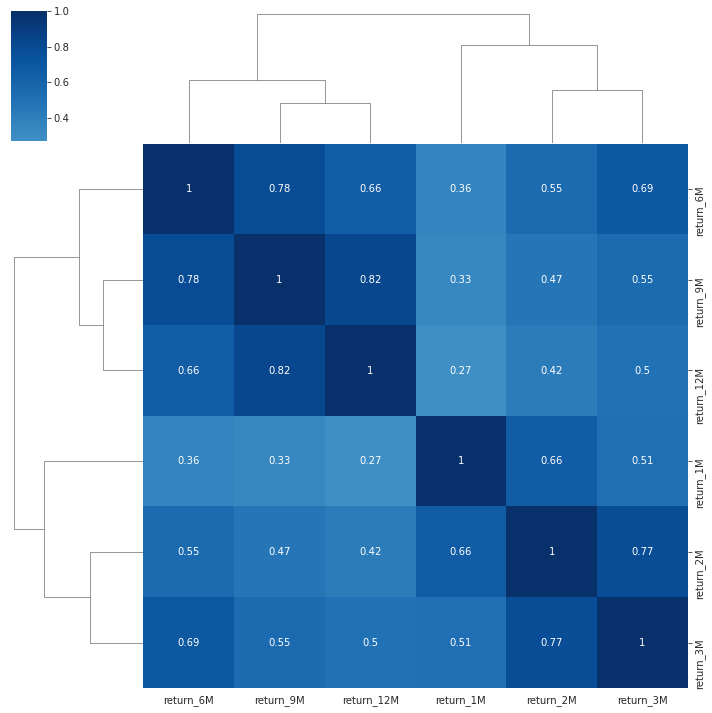

In [31]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

We are left with 1,670 tickers.

In [32]:
# data.index.get_level_values(['symbol', 'base']).nunique()
data.index.get_level_values('symbol').unique(), data.index.get_level_values('symbol').nunique(), data.index.get_level_values('base').nunique()

(Index(['btc', 'ltc', 'eth', 'etc', 'xmr', 'xrp', 'miota', 'eos', 'neo', 'trx',
        'dai', 'mkr', 'xlm', 'vet', 'xtz', 'bsv', 'usdc', 'usdt', 'btt', 'atom',
        'wbtc'],
       dtype='object', name='symbol'),
 21,
 1)

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 9, Time Series Models](../09_time_series_models).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `RollingOLS` rolling linear regression functionality in the `statsmodels` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [33]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample(timeframe).last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255 entries, 2000-01-31 to 2021-03-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  255 non-null    float64
 1   SMB     255 non-null    float64
 2   HML     255 non-null    float64
 3   RMW     255 non-null    float64
 4   CMA     255 non-null    float64
dtypes: float64(5)
memory usage: 12.0 KB


In [34]:
factor_data = factor_data.join(data[f'return_1{timeframe}']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 906 entries, (Timestamp('2013-04-30 00:00:00', freq='M'), 'btc', 'usd') to (Timestamp('2021-03-31 00:00:00', freq='M'), 'xtz', 'usd')
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     906 non-null    float64
 1   SMB        906 non-null    float64
 2   HML        906 non-null    float64
 3   RMW        906 non-null    float64
 4   CMA        906 non-null    float64
 5   return_1M  885 non-null    float64
dtypes: float64(6)
memory usage: 57.7+ KB


In [35]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1M
count,906.000000,906.000000,906.000000,906.000000,906.000000,885.000000
mean,0.014054,0.001840,-0.007215,0.001011,-0.001674,0.102546
std,0.051435,0.031457,0.037824,0.018071,0.018063,0.445101
min,-0.133800,-0.083800,-0.139600,-0.039300,-0.033500,-0.471383
25%,-0.001100,-0.019100,-0.025100,-0.011500,-0.014400,-0.146294
50%,0.019400,0.002000,-0.013600,0.000900,-0.003800,-0.000299
75%,0.038700,0.019400,0.014500,0.008600,0.010500,0.226130
max,0.136500,0.068800,0.082200,0.064300,0.046800,2.439051


In [36]:
factor_data.head(10)

Mkt-RF     SMB     HML     RMW     CMA  return_1M
date       symbol base                                                   
2013-04-30 btc    usd   0.0155 -0.0228  0.0053  0.0013  0.0048        NaN
2013-05-31 btc    usd   0.0280  0.0200  0.0261 -0.0201 -0.0074  -0.085287
           ltc    usd   0.0280  0.0200  0.0261 -0.0201 -0.0074        NaN
2013-06-30 btc    usd  -0.0120  0.0135 -0.0009 -0.0035 -0.0002  -0.300117
           ltc    usd  -0.0120  0.0135 -0.0009 -0.0035 -0.0002  -0.049489
2013-07-31 btc    usd   0.0565  0.0181  0.0056 -0.0133  0.0055   0.096371
           ltc    usd   0.0565  0.0181  0.0056 -0.0133  0.0055  -0.013007
2013-08-31 btc    usd  -0.0271 -0.0003 -0.0266  0.0059 -0.0218   0.301691
           ltc    usd  -0.0271 -0.0003 -0.0266  0.0059 -0.0218  -0.065891
2013-09-30 btc    usd   0.0377  0.0265 -0.0115 -0.0060 -0.0126  -0.014476

In [37]:
T = 24
betas = (factor_data.groupby(level='symbol',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x[f'return_1{timeframe}'],
                                     exog=sm.add_constant(x.drop(f'return_1{timeframe}', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [38]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,426.000000,426.000000,426.000000,426.000000,426.000000,906.000000
mean,0.819256,-0.742253,-1.035056,2.878040,0.326473,1.056282
std,1.768994,3.508994,3.372013,8.665479,6.162487,7.259653
min,-8.357970,-10.671231,-14.521548,-27.119256,-19.285862,-27.418097
25%,0.038374,-2.838090,-2.218172,-1.737595,-3.561567,0.000000
50%,0.820761,-0.722384,-0.424688,3.064818,-0.417532,0.000000
75%,1.745097,1.403280,0.759190,7.660606,3.199323,1.495646
max,4.798577,9.569106,6.331182,28.013475,23.309071,47.474588


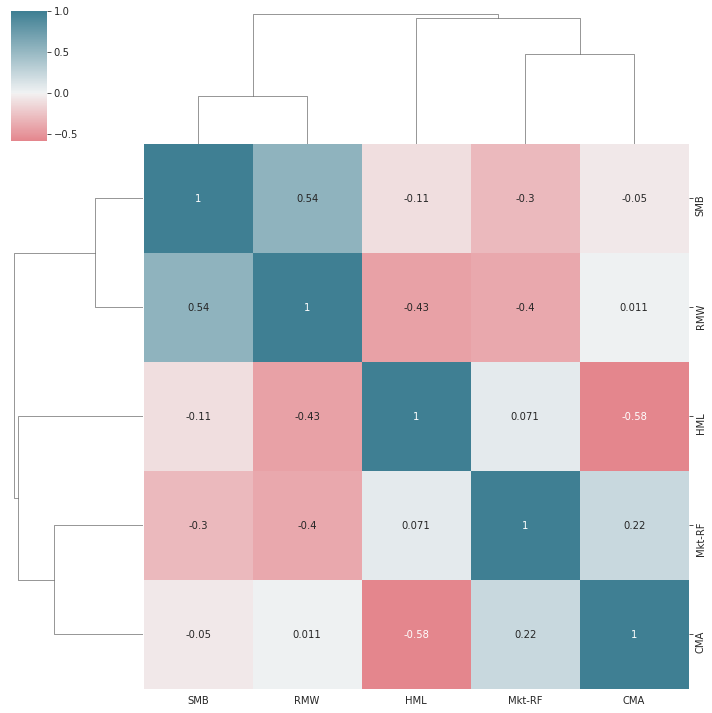

In [39]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [40]:
data = (data
        .join(betas
              .groupby(level='symbol')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 948 entries, (Timestamp('2013-04-30 00:00:00', freq='M'), 'btc', 'usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xtz', 'usd')
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1M   927 non-null    float64
 1   return_2M   906 non-null    float64
 2   return_3M   885 non-null    float64
 3   return_6M   822 non-null    float64
 4   return_9M   759 non-null    float64
 5   return_12M  696 non-null    float64
 6   Mkt-RF      405 non-null    float64
 7   SMB         405 non-null    float64
 8   HML         405 non-null    float64
 9   RMW         405 non-null    float64
 10  CMA         405 non-null    float64
dtypes: float64(11)
memory usage: 121.0+ KB


### Impute mean for missing factor betas

In [41]:
data.loc[:, factors] = data.groupby('symbol')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 948 entries, (Timestamp('2013-04-30 00:00:00', freq='M'), 'btc', 'usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xtz', 'usd')
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1M   927 non-null    float64
 1   return_2M   906 non-null    float64
 2   return_3M   885 non-null    float64
 3   return_6M   822 non-null    float64
 4   return_9M   759 non-null    float64
 5   return_12M  696 non-null    float64
 6   Mkt-RF      948 non-null    float64
 7   SMB         948 non-null    float64
 8   HML         948 non-null    float64
 9   RMW         948 non-null    float64
 10  CMA         948 non-null    float64
dtypes: float64(11)
memory usage: 121.0+ KB


## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [42]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}{timeframe}'].sub(data[f'return_1{timeframe}'])
data[f'momentum_3_12'] = data[f'return_12{timeframe}'].sub(data[f'return_3{timeframe}'])

## Date Indicators

In [43]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [44]:
for t in range(1, 7):
    data[f'return_1{timeframe}_t-{t}'] = data.groupby(level='symbol')[f'return_1{timeframe}'].shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 948 entries, (Timestamp('2013-04-30 00:00:00', freq='M'), 'btc', 'usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xtz', 'usd')
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1M      927 non-null    float64
 1   return_2M      906 non-null    float64
 2   return_3M      885 non-null    float64
 3   return_6M      822 non-null    float64
 4   return_9M      759 non-null    float64
 5   return_12M     696 non-null    float64
 6   Mkt-RF         948 non-null    float64
 7   SMB            948 non-null    float64
 8   HML            948 non-null    float64
 9   RMW            948 non-null    float64
 10  CMA            948 non-null    float64
 11  momentum_2     906 non-null    float64
 12  momentum_3     885 non-null    float64
 13  momentum_6     822 non-null    float64
 14  momentum_9     759 non-null    float64
 15  momentum_12    696 non-null   

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [45]:
for t in [1,2,3,6,12]:
    data[f'target_{t}{timeframe}'] = data.groupby(level='symbol')[f'return_{t}{timeframe}'].shift(-t)

In [46]:
data.columns.values.tolist(), timeframe

(['return_1M',
  'return_2M',
  'return_3M',
  'return_6M',
  'return_9M',
  'return_12M',
  'Mkt-RF',
  'SMB',
  'HML',
  'RMW',
  'CMA',
  'momentum_2',
  'momentum_3',
  'momentum_6',
  'momentum_9',
  'momentum_12',
  'momentum_3_12',
  'year',
  'month',
  'return_1M_t-1',
  'return_1M_t-2',
  'return_1M_t-3',
  'return_1M_t-4',
  'return_1M_t-5',
  'return_1M_t-6',
  'target_1M',
  'target_2M',
  'target_3M',
  'target_6M',
  'target_12M'],
 'M')

In [47]:
cols = [f'target_1{timeframe}',
        f'target_2{timeframe}',
        f'target_3{timeframe}',
        f'return_1{timeframe}',
        f'return_2{timeframe}',
        f'return_3{timeframe}',
        f'return_1{timeframe}_t-1',
        f'return_1{timeframe}_t-2',
        f'return_1{timeframe}_t-3']

data[cols].dropna().sort_index().head(10)

target_1M  target_2M  target_3M  return_1M  return_2M  \
date       symbol base                                                          
2013-08-31 btc    usd   -0.014476   0.258834   1.061103   0.301691   0.194628   
2013-09-30 btc    usd    0.607940   1.894662   0.796275  -0.014476   0.132629   
           ltc    usd    0.015556   1.894662   1.195122  -0.066390  -0.066141   
2013-10-31 btc    usd    2.439051   0.898561   0.583091   0.607940   0.258834   
           ltc    usd    2.439051   1.894662   1.096641   0.015556  -0.026279   
2013-11-30 btc    usd   -0.347641  -0.152621  -0.209442   2.439051   1.894662   
           ltc    usd   -0.397494  -0.269819  -0.293887   2.439051   1.894662   
2013-12-31 btc    usd    0.100700  -0.129724  -0.144852  -0.347641   0.898561   
           ltc    usd   -0.115089  -0.246840  -0.187187  -0.397494   1.894662   
2014-01-31 btc    usd   -0.311910  -0.246250  -0.176317   0.100700  -0.152621   

                        return_3M  return_1M_t-1  return_1M_t-2  return_1M_t-3  
date       symbol base                                                          
2013-08-31 btc    usd   -0.000391       0.096371      -0.300117      -0.085287  
2013-09-30 btc    usd    0.120411       0.301691       0.096371      -0.300117  
           ltc    usd   -0.048755      -0.065891      -0.013007      -0.049489  
2013-10-31 btc    usd    0.272961      -0.014476       0.301691       0.096371  
           ltc    usd   -0.039666      -0.066390      -0.065891      -0.013007  
2013-11-30 btc    usd    1.061103       0.607940      -0.014476       0.301691  
           ltc    usd    1.195635       0.015556      -0.066390      -0.065891  
2013-12-31 btc    usd    0.796275       2.439051       0.607940      -0.014476  
           ltc    usd    1.195122       2.439051       0.015556      -0.066390  
2014-01-31 btc    usd    0.583091      -0.347641       2.439051       0.607940

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 948 entries, (Timestamp('2013-04-30 00:00:00', freq='M'), 'btc', 'usd') to (Timestamp('2021-05-31 00:00:00', freq='M'), 'xtz', 'usd')
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1M      927 non-null    float64
 1   return_2M      906 non-null    float64
 2   return_3M      885 non-null    float64
 3   return_6M      822 non-null    float64
 4   return_9M      759 non-null    float64
 5   return_12M     696 non-null    float64
 6   Mkt-RF         948 non-null    float64
 7   SMB            948 non-null    float64
 8   HML            948 non-null    float64
 9   RMW            948 non-null    float64
 10  CMA            948 non-null    float64
 11  momentum_2     906 non-null    float64
 12  momentum_3     885 non-null    float64
 13  momentum_6     822 non-null    float64
 14  momentum_9     759 non-null    float64
 15  momentum_12    696 non-null   

## Create age proxy

We use quintiles of IPO year as a proxy for company age.

In [49]:
age_quintiles = pd.qcut(cryptos['genesis_date'], q=5, labels=list(range(1, 6))).astype(float).fillna(0).astype(int).to_frame('age')
age_quintiles

,,age
symbol,base,
btc,usd,1
ltc,usd,1
eth,usd,2
etc,usd,2
xmr,usd,2
xrp,usd,0
miota,usd,0
eos,usd,4
neo,usd,3


In [50]:
data = data.join(age_quintiles)
# data.age = data.age.fillna(-1)

In [51]:
data['age']

symbol  base  date      
atom    usd   2019-04-30    0
              2019-05-31    0
              2019-06-30    0
              2019-07-31    0
              2019-08-31    0
                           ..
xtz     usd   2021-01-31    0
              2021-02-28    0
              2021-03-31    0
              2021-04-30    0
              2021-05-31    0
Name: age, Length: 948, dtype: int64

## Create dynamic size proxy

We use the marketcap information from the NASDAQ ticker info to create a size proxy.

In [52]:
cryptos.info()



<class 'pandas.core.frame.DataFrame'>
MultiIndex: 35 entries, ('btc', 'usd') to ('bch', 'usd')
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     35 non-null     object        
 1   market_cap             35 non-null     int64         
 2   name                   35 non-null     object        
 3   genesis_date           12 non-null     datetime64[ns]
 4   market_cap_rank        35 non-null     int64         
 5   hashing_algorithm      35 non-null     object        
 6   coingecko_rank         35 non-null     int64         
 7   coingecko_score        35 non-null     float64       
 8   developer_score        35 non-null     float64       
 9   community_score        35 non-null     float64       
 10  liquidity_score        35 non-null     float64       
 11  public_interest_score  35 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(3

Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [53]:
prices_resampled.close.unstack(level=[1, 2]).tail(2)

symbol,btc,ltc,eth,etc,xmr,xrp,miota,eos,neo,trx,...,mkr,xlm,vet,xtz,bsv,usdc,usdt,btt,atom,wbtc
base,usd,usd,usd,usd,usd,usd,usd,usd,usd,usd,...,usd,usd,usd,usd,usd,usd,usd,usd,usd,usd
date,,,,,,,,,,,,,,,,,,,,,
2021-04-30,57649.15327,270.84,2768.7,36.304,422.17,1.5909,2.1313,6.4324,97.063,0.13213,...,4345.6,0.52884,0.20070,5.6034,323.21,0.99840,0.99953,0.007235,22.688,57426.0
2021-05-31,45745.00000,307.63,3546.0,93.828,356.10,1.5415,1.9899,9.6933,90.822,0.11777,...,4852.3,0.67117,0.17048,5.5380,293.13,0.99921,0.99949,0.005635,22.764,45016.0


In [54]:
prices_unstacked = prices_resampled.close.unstack(level=[1, 2])

In [55]:
prices_unstacked.iloc[-1]


symbol  base
btc     usd     45745.000000
ltc     usd       307.630000
eth     usd      3546.000000
etc     usd        93.828000
xmr     usd       356.100000
xrp     usd         1.541500
miota   usd         1.989900
eos     usd         9.693300
neo     usd        90.822000
trx     usd         0.117770
dai     usd         0.999400
mkr     usd      4852.300000
xlm     usd         0.671170
vet     usd         0.170480
xtz     usd         5.538000
bsv     usd       293.130000
usdc    usd         0.999210
usdt    usd         0.999490
btt     usd         0.005635
atom    usd        22.764000
wbtc    usd     45016.000000
Name: 2021-05-31 00:00:00, dtype: float64

In [56]:
market_cap = prices_unstacked/prices_unstacked.iloc[-1]*cryptos['market_cap']
# market_cap = market_cap.stack([0,1])
market_cap

symbol,aave,ada,algo,atom,bch,bsv,btc,btt,dai,doge,...,trx,uni,usdc,usdt,vet,wbtc,xlm,xmr,xrp,xtz
base,usd,usd,usd,usd,usd,usd,usd,usd,usd,usd,...,usd,usd,usd,usd,usd,usd,usd,usd,usd,usd
date,,,,,,,,,,,,,,,,,,,,,
2013-04-30,NaN,NaN,NaN,NaN,NaN,NaN,2.602712e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-31,NaN,NaN,NaN,NaN,NaN,NaN,2.380733e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-30,NaN,NaN,NaN,NaN,NaN,NaN,1.666234e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-31,NaN,NaN,NaN,NaN,NaN,NaN,1.826810e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-31,NaN,NaN,NaN,NaN,NaN,NaN,2.377942e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,NaN,NaN,NaN,1.965151e+09,NaN,3.334395e+09,6.163857e+11,2.542186e+08,4.786430e+09,NaN,...,2.300637e+09,NaN,1.688932e+10,5.849447e+10,1.662936e+09,5.744766e+09,7.360505e+09,2.467164e+09,2.505528e+10,2.482026e+09
2021-02-28,NaN,NaN,NaN,4.259253e+09,NaN,3.400128e+09,8.413041e+11,7.769966e+08,4.803657e+09,NaN,...,3.322713e+09,NaN,1.689946e+10,5.860551e+10,2.636834e+09,8.179053e+09,9.724926e+09,3.926229e+09,2.098178e+10,2.989640e+09


### Create Size indicator as deciles per period

Compute size deciles per month:

In [57]:
market_cap_deciles = market_cap.dropna(axis=0, thresh=2).apply(lambda x: pd.qcut(x, q=5, labels=list(range(1, 6))), axis=1, )
market_cap_deciles = market_cap_deciles.stack([0, 1])
market_cap_deciles.index.set_names(['date', 'symbol', 'base'], inplace=True)
market_cap_deciles.rename('msize', inplace=True)
market_cap_deciles

date        symbol  base
2013-05-31  btc     usd     5
            ltc     usd     1
2013-06-30  btc     usd     5
            ltc     usd     1
2013-07-31  btc     usd     5
                           ..
2021-05-31  wbtc    usd     3
            xlm     usd     4
            xmr     usd     2
            xrp     usd     5
            xtz     usd     1
Name: msize, Length: 947, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [58]:
data = data.join(market_cap_deciles)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 948 entries, ('atom', 'usd', Timestamp('2019-04-30 00:00:00', freq='M')) to ('xtz', 'usd', Timestamp('2021-05-31 00:00:00', freq='M'))
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   return_1M      927 non-null    float64 
 1   return_2M      906 non-null    float64 
 2   return_3M      885 non-null    float64 
 3   return_6M      822 non-null    float64 
 4   return_9M      759 non-null    float64 
 5   return_12M     696 non-null    float64 
 6   Mkt-RF         948 non-null    float64 
 7   SMB            948 non-null    float64 
 8   HML            948 non-null    float64 
 9   RMW            948 non-null    float64 
 10  CMA            948 non-null    float64 
 11  momentum_2     906 non-null    float64 
 12  momentum_3     885 non-null    float64 
 13  momentum_6     822 non-null    float64 
 14  momentum_9     759 non-null    float64 
 15  momentum_12 

In [60]:
data.tail()

return_1M  return_2M  return_3M  return_6M  return_9M  \
symbol base date                                                                
xtz    usd  2021-01-31   0.413311   0.068956   0.128085   0.001041   0.003507   
            2021-02-28   0.204516   0.304744   0.112357   0.008372   0.022641   
            2021-03-31   0.409601   0.303030   0.338799   0.139939   0.082361   
            2021-04-30   0.160701   0.279111   0.253746   0.189257   0.079041   
            2021-05-31  -0.011671   0.071053   0.173742   0.142637   0.060730   

                        return_12M    Mkt-RF       SMB       HML       RMW  \
symbol base date                                                             
xtz    usd  2021-01-31    0.046035  2.265159 -6.397271  2.872858 -3.113144   
            2021-02-28    0.017914  2.250871 -3.743156  1.834846 -4.960936   
            2021-03-31    0.095618  2.256593 -3.605989  1.678074 -4.834858   
            2021-04-30    0.060945  1.889347 -5.137280  2.214039 -1.882954   
            2021-05-31    0.058487  1.889347 -5.137280  2.214039 -1.882954   

                        ...  return_1M_t-4  return_1M_t-5  return_1M_t-6  \
symbol base date        ...                                                
xtz    usd  2021-01-31  ...      -0.324646       0.152923       0.193243   
            2021-02-28  ...      -0.099768      -0.324646       0.152923   
            2021-03-31  ...       0.256336      -0.099768      -0.324646   
            2021-04-30  ...      -0.191496       0.256336      -0.099768   
            2021-05-31  ...       0.413311      -0.191496       0.256336   

                        target_1M  target_2M  target_3M  target_6M  \
symbol base date                                                     
xtz    usd  2021-01-31   0.204516   0.303030   0.253746        NaN   
            2021-02-28   0.409601   0.279111   0.173742        NaN   
            2021-03-31   0.160701   0.071053        NaN        NaN   
            2021-04-30  -0.011671        NaN        NaN        NaN   
            2021-05-31        NaN        NaN        NaN        NaN   

                        target_12M  age  msize  
symbol base date                                
xtz    usd  2021-01-31         NaN    0      3  
            2021-02-28         NaN    0      2  
            2021-03-31         NaN    0      2  
            2021-04-30         NaN    0      1  
            2021-05-31         NaN    0      1  

[5 rows x 32 columns]

## Store data

We will use the data again in several later chapters, starting in [Chapter 7 on Linear Models](../07_linear_models).

In [64]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index(), format='t')
    print(store.info())




<class 'pandas.io.pytables.HDFStore'>
File path: ../data/crypto.h5
/coingecko/top100/cats                                   frame        (shape->[100,49])                                                                    
/coingecko/top100/market                                 frame        (shape->[100,12])                                                                    
/crypto/caggle/prices                                    frame        (shape->[48918134,5])                                                                
/engineered_features                                     frame_table  (typ->appendable_multi,nrows->948,ncols->35,indexers->[index],dc->[date,base,symbol])
/engineered_features/meta/values_block_2/meta            series_table (typ->appendable,nrows->5,ncols->1,indexers->[index],dc->[values])                   
